# RBFNN

Radial Basis Function Neural Network using Tensorflow.

## Reference
* https://stackoverflow.com/questions/45853863/problems-with-my-rbf-network-in-tensorflow
* https://github.com/oarriaga/RBF-Network
* https://github.com/cdusold/TensorFlowRBF

![alt text](https://www.researchgate.net/profile/Prakash_V_R/publication/264972112/figure/fig1/AS:295911268864003@1447562152256/Structure-of-Radial-Basis-Function-Neural-Network-There-are-many-basis-functions-such-as.png)

In [0]:
import tensorflow as tf
import numpy as np
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
ops.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

boston = datasets.load_boston()

data = boston["data"]
target = boston["target"]

N_INSTANCES = data.shape[0] 
# N_INPUT = data.shape[1] - 1
N_INPUT = data.shape[1] # modified to move on... 
N_CLASSES = 3
TEST_SIZE = 0.1
TRAIN_SIZE = int(N_INSTANCES * (1 - TEST_SIZE))
batch_size = 40
training_epochs = 400
learning_rate = 0.001
display_step = 20
hidden_size = 200

target_ = np.zeros((N_INSTANCES, N_CLASSES))

data_train, data_test, target_train, target_test = train_test_split(data, target_, test_size=0.1, random_state=100)

x_data = tf.placeholder(shape=[None, N_INPUT], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32)

# creates activation function
def gaussian_function(input_layer):
    initial = math.exp(-2*math.pow(input_layer, 2))
    return initial

np_gaussian_function = np.vectorize(gaussian_function)

def d_gaussian_function(input_layer):
    initial = -4 * input_layer * math.exp(-2*math.pow(input_layer, 2))
    return initial

np_d_gaussian_function = np.vectorize(d_gaussian_function)

np_d_gaussian_function_32 = lambda input_layer: np_d_gaussian_function(input_layer).astype(np.float32)

def tf_d_gaussian_function(input_layer, name=None):
    with ops.name_scope(name, "d_gaussian_function", [input_layer]) as name:
        y = tf.py_func(np_d_gaussian_function_32, [input_layer],[tf.float32], name=name, stateful=False)
    return y[0]

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    rnd_name = 'PyFunGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

def gaussian_function_grad(op, grad):
    input_variable = op.inputs[0]
    n_gr = tf_d_gaussian_function(input_variable)
    return grad * n_gr

np_gaussian_function_32 = lambda input_layer: np_gaussian_function(input_layer).astype(np.float32)

def tf_gaussian_function(input_layer, name=None):
    with ops.name_scope(name, "gaussian_function", [input_layer]) as name:
        y = py_func(np_gaussian_function_32, [input_layer], [tf.float32], name=name, grad=gaussian_function_grad)
    return y[0]
# end of defining activation function

def rbf_network(input_layer, weights):
    layer1 = tf.matmul(tf_gaussian_function(input_layer), weights['h1'])
    layer2 = tf.matmul(tf_gaussian_function(layer1), weights['h2'])
    output = tf.matmul(tf_gaussian_function(layer2), weights['output'])
    return output

weights = {
    'h1': tf.Variable(tf.random_normal([N_INPUT, hidden_size], stddev=0.1)),
    'h2': tf.Variable(tf.random_normal([hidden_size, hidden_size], stddev=0.1)),
    'output': tf.Variable(tf.random_normal([hidden_size, N_CLASSES], stddev=0.1))
}

pred = rbf_network(x_data, weights)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target))
# Plus boston dataset is a regression problem while softmax_cross_entropy is a 
# cost function for classification problem. You can try tf.square to evaluate 
# the euclidean distance between what you are predicting and what you want :
cost = tf.reduce_mean(tf.square(pred - y_target))
my_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

# Training loop
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(data_train.shape[0] / batch_size)
    for i in range(total_batch):
        randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
        batch_xs = data_train[randidx, :]
        batch_ys = target_train[randidx, :]

        sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
        avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch

        if epoch % display_step == 0:
            print("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_accuracy = sess.run(accuracy, feed_dict={x_data: batch_xs, y_target: batch_ys})
            print("Training accuracy: %.3f" % train_accuracy)

test_acc = sess.run(accuracy, feed_dict={x_data: data_test, y_target: target_test})
print("Test accuracy: %.3f" % (test_acc))

sess.close()

Epoch: 000/400 cost: 0.008645537
Training accuracy: 0.000
Epoch: 000/400 cost: 0.014919221
Training accuracy: 0.000
Epoch: 000/400 cost: 0.019687488
Training accuracy: 0.000
Epoch: 000/400 cost: 0.023174066
Training accuracy: 0.000
Epoch: 000/400 cost: 0.025618254
Training accuracy: 0.000
Epoch: 000/400 cost: 0.027452142
Training accuracy: 0.000
Epoch: 000/400 cost: 0.028849815
Training accuracy: 0.000
Epoch: 000/400 cost: 0.029895688
Training accuracy: 0.000
Epoch: 000/400 cost: 0.030682941
Training accuracy: 0.000
Epoch: 000/400 cost: 0.031269785
Training accuracy: 0.000
Epoch: 000/400 cost: 0.031716872
Training accuracy: 0.025
Epoch: 020/400 cost: 0.000031062
Training accuracy: 0.125
Epoch: 020/400 cost: 0.000055320
Training accuracy: 0.025
Epoch: 020/400 cost: 0.000082962
Training accuracy: 0.125
Epoch: 020/400 cost: 0.000114205
Training accuracy: 0.075
Epoch: 020/400 cost: 0.000149260
Training accuracy: 0.100
Epoch: 020/400 cost: 0.000179273
Training accuracy: 0.150
Epoch: 020/400

Epoch: 200/400 cost: 0.000061948
Training accuracy: 0.175
Epoch: 200/400 cost: 0.000075036
Training accuracy: 0.225
Epoch: 200/400 cost: 0.000084677
Training accuracy: 0.375
Epoch: 200/400 cost: 0.000093608
Training accuracy: 0.250
Epoch: 200/400 cost: 0.000103860
Training accuracy: 0.300
Epoch: 200/400 cost: 0.000115726
Training accuracy: 0.225
Epoch: 220/400 cost: 0.000008380
Training accuracy: 0.175
Epoch: 220/400 cost: 0.000013289
Training accuracy: 0.175
Epoch: 220/400 cost: 0.000021530
Training accuracy: 0.200
Epoch: 220/400 cost: 0.000030830
Training accuracy: 0.375
Epoch: 220/400 cost: 0.000042930
Training accuracy: 0.300
Epoch: 220/400 cost: 0.000050201
Training accuracy: 0.150
Epoch: 220/400 cost: 0.000059036
Training accuracy: 0.250
Epoch: 220/400 cost: 0.000070267
Training accuracy: 0.400
Epoch: 220/400 cost: 0.000081135
Training accuracy: 0.250
Epoch: 220/400 cost: 0.000098139
Training accuracy: 0.375
Epoch: 220/400 cost: 0.000115635
Training accuracy: 0.375
Epoch: 240/400

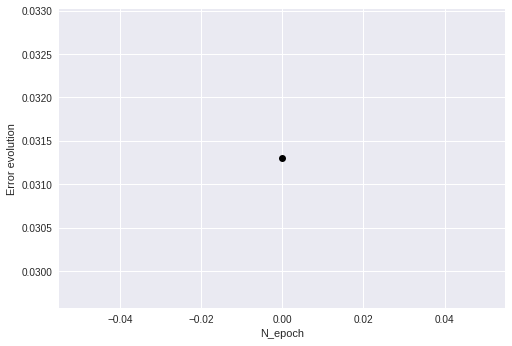

Epoch: 0/4000 err = 0.03129867430437695


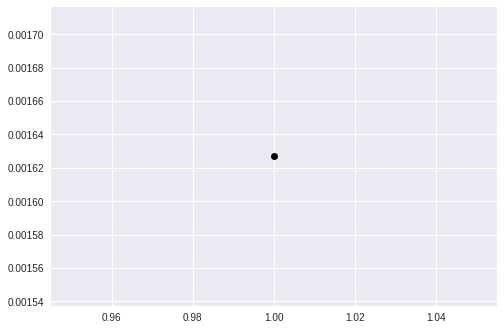

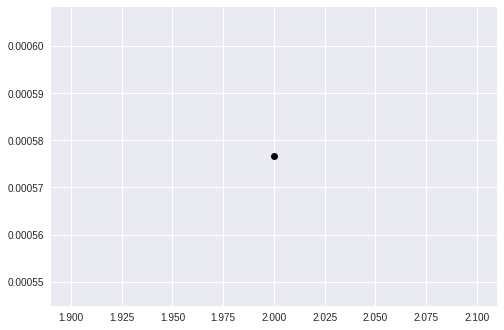

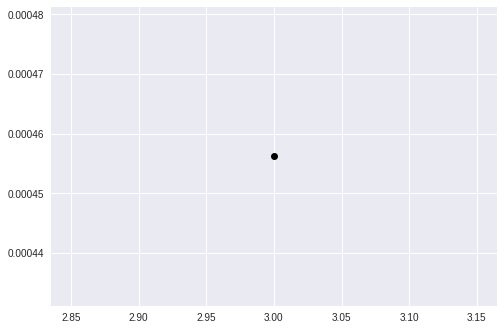

End of learning process
Final epoch = 4/4000 
Final error = 0.00045619397529993546


In [0]:
import tensorflow as tf
import numpy as np
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

ops.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

boston = datasets.load_boston()

data = boston["data"]
target = boston["target"]

N_INSTANCES = data.shape[0] 
# N_INPUT = data.shape[1] - 1
N_INPUT = data.shape[1] # modified to move on... 
N_CLASSES = 3
TEST_SIZE = 0.1
TRAIN_SIZE = int(N_INSTANCES * (1 - TEST_SIZE))
batch_size = 40
training_epochs = 4000
learning_rate = 0.001
display_step = 20
hidden_size = 200

target_ = np.zeros((N_INSTANCES, N_CLASSES))

data_train, data_test, target_train, target_test = train_test_split(data, target_, test_size=0.1, random_state=100)

x_data = tf.placeholder(shape=[None, N_INPUT], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, N_CLASSES], dtype=tf.float32)

# creates activation function
def gaussian_function(input_layer):
    initial = math.exp(-2*math.pow(input_layer, 2))
    return initial

np_gaussian_function = np.vectorize(gaussian_function)

def d_gaussian_function(input_layer):
    initial = -4 * input_layer * math.exp(-2*math.pow(input_layer, 2))
    return initial

np_d_gaussian_function = np.vectorize(d_gaussian_function)

np_d_gaussian_function_32 = lambda input_layer: np_d_gaussian_function(input_layer).astype(np.float32)

def tf_d_gaussian_function(input_layer, name=None):
    with ops.name_scope(name, "d_gaussian_function", [input_layer]) as name:
        y = tf.py_func(np_d_gaussian_function_32, [input_layer],[tf.float32], name=name, stateful=False)
    return y[0]

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    rnd_name = 'PyFunGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

def gaussian_function_grad(op, grad):
    input_variable = op.inputs[0]
    n_gr = tf_d_gaussian_function(input_variable)
    return grad * n_gr

np_gaussian_function_32 = lambda input_layer: np_gaussian_function(input_layer).astype(np.float32)

def tf_gaussian_function(input_layer, name=None):
    with ops.name_scope(name, "gaussian_function", [input_layer]) as name:
        y = py_func(np_gaussian_function_32, [input_layer], [tf.float32], name=name, grad=gaussian_function_grad)
    return y[0]
# end of defining activation function

def rbf_network(input_layer, weights):
    layer1 = tf.matmul(tf_gaussian_function(input_layer), weights['h1'])
    layer2 = tf.matmul(tf_gaussian_function(layer1), weights['h2'])
    output = tf.matmul(tf_gaussian_function(layer2), weights['output'])
    return output

weights = {
    'h1': tf.Variable(tf.random_normal([N_INPUT, hidden_size], stddev=0.1)),
    'h2': tf.Variable(tf.random_normal([hidden_size, hidden_size], stddev=0.1)),
    'output': tf.Variable(tf.random_normal([hidden_size, N_CLASSES], stddev=0.1))
}

pred = rbf_network(x_data, weights)

cost = tf.reduce_mean(tf.square(pred - y_target))
my_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

plt.figure("Error evolution")
plt.xlabel("N_epoch")
plt.ylabel("Error evolution")
tol = 5e-4
epoch, err=0, 1
# Training loop
while epoch <= training_epochs and err >= tol:
    avg_cost = 0.
    total_batch = int(data_train.shape[0] / batch_size)
    for i in range(total_batch):
        randidx = np.random.randint(int(TRAIN_SIZE), size=batch_size)
        batch_xs = data_train[randidx, :]
        batch_ys = target_train[randidx, :]

        sess.run(my_opt, feed_dict={x_data: batch_xs, y_target: batch_ys})
        avg_cost += sess.run(cost, feed_dict={x_data: batch_xs, y_target: batch_ys})/total_batch
    plt.plot(epoch, avg_cost, marker='o', linestyle="none", c='k')
    plt.pause(0.05)
    err = avg_cost
    if epoch % 10 == 0:
        print("Epoch: {}/{} err = {}".format(epoch, training_epochs, avg_cost))

    epoch +=1

print ("End of learning process")
print ("Final epoch = {}/{} ".format(epoch, training_epochs))
print ("Final error = {}".format(err) )
sess.close()
